In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
import time
import requests
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import praw
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import MultinomialNB
from IPython.core.interactiveshell import InteractiveShell
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

### I read in my combined cleaned data from notebook 1

In [2]:
df=pd.read_csv('./data/AlienAbductionsSleepParalysisCLEANED.csv')

In [ ]:
df.head(10)

### I created new columns for body length, body word count, title length, title word count to compare

In [9]:
stop=stopwords.words('english')

In [10]:
wordlist2=['like','back','would','know','see','get','one','could',
           'something','really','alien','aliens','abduction','sp',
           'sleep','paralysis']

# Vectorize

In [16]:
vectorizer=CountVectorizer(analyzer='word',
                          tokenizer=None,
                          preprocessor=None,
                          stop_words=stop,
                          
                          min_df=.07,
                          ngram_range=(1,2))

In [17]:
X_vec=vectorizer.fit_transform(df['body'])

In [18]:
X_vecdf=pd.DataFrame(X_vec.toarray(),columns=vectorizer.get_feature_names())

In [19]:
X_vecdf.head()

10  able  actually  ago  almost  also  always  another  anyone  \
0   0     0         0    0       0     0       0        0       0   
1   0     1         0    0       0     0       0        0       1   
2   1     0         0    0       0     0       0        0       0   
3   0     0         0    0       0     0       0        0       0   
4   0     0         0    0       0     0       0        0       0   

   anyone else  ...  well  went  white  whole  window  woke  work  year  \
0            0  ...     0     0      0      0       0     0     0     0   
1            0  ...     0     0      0      1       0     0     0     0   
2            0  ...     0     1      0      0       3     1     0     0   
3            0  ...     0     0      0      0       0     0     0     0   
4            0  ...     0     0      0      0       0     0     0     0   

   years  years ago  
0      0          0  
1      0          0  
2      0          0  
3      0          0  
4      0          0  

[5 rows x 219 columns]

In [43]:
df = pd.concat([df, X_vecdf],axis=1)

# Logistic Regression

In [44]:
lr=LogisticRegression()

In [45]:
X=df.drop(columns=['title','body','subreddit2','num_comments'])
y=df['subreddit2']

In [ ]:
y.shape

## Train Test Split, Fit and Score

In [46]:
X_train,X_test,y_train,y_test=train_test_split(X_vec,y,test_size=.33,random_state=42)

In [47]:
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
#lr.fit(X_test,y_test)

In [48]:
lr.score(X_train,y_train)

0.9219562955254943

In [49]:
lr.score(X_test,y_test)

0.8502109704641351

## y value counts

In [50]:
y.value_counts(normalize = True)

1    0.579094
0    0.420906
Name: subreddit2, dtype: float64

In [51]:
# I got this and the bar chart from class notes
top_words = {}

# loop through columns
for i in X_vecdf.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_vecdf[i].sum()

most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

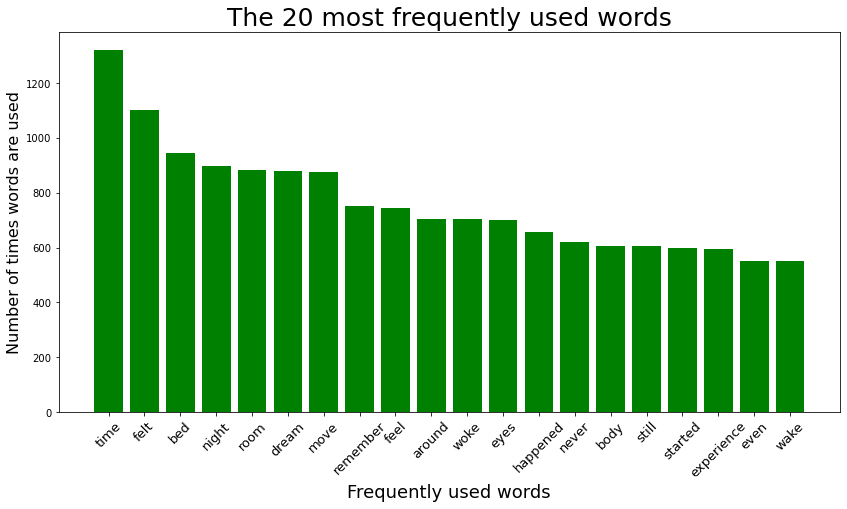

In [52]:
plt.figure(figsize = (14, 7))

# bar chart of the top 20 words
plt.bar(most_freq[0][:20],most_freq[1][:20],color='green')
plt.title('The 20 most frequently used words',size=25)
plt.xlabel('Frequently used words',size=18)
plt.ylabel('Number of times words are used',size=16)
plt.xticks(rotation=45,size=13);

In [54]:
y_train_baseline = [y_train.mean()]*len(y_train)     
y_test_baseline  = [y_train.mean()]*len(y_test)

In [55]:
lr.coef_[0]

array([ 0.09910265,  0.74272632,  0.7669373 , -0.70561721, -0.52406575,
       -0.27544153, -0.72355649,  0.05772692,  0.75163728,  0.70327759,
       -0.74289861, -0.13287749,  1.37708997,  0.56969889, -0.68231389,
        1.44405075,  0.21948131, -0.97948862,  0.00708667, -0.81740993,
        1.01499862,  0.08298977,  0.56676763,  0.16457745,  0.47199899,
        0.52781611, -1.20202054, -0.11848767,  0.1538764 , -0.55929195,
       -0.75850927,  0.15041862, -0.32631684,  0.03637708,  0.12460815,
        1.09084505,  0.36439207, -0.21611775, -0.31278102,  1.05561608,
        1.59478499, -0.69827512,  0.35456143,  0.39168657,  0.55111165,
       -0.45065138,  0.46116824,  1.05609798, -0.69134027,  0.39661505,
        1.26925295, -0.29327732, -0.11715936,  0.75076591,  0.20866806,
        0.39538425, -0.44608467, -0.06759408,  0.1618299 ,  0.97903667,
       -0.08957326, -0.23826865,  0.37865271,  0.26500043, -0.34711411,
        0.03266958,  0.38240026,  0.00246154,  0.20629723,  0.22

### RMSE and Cross Val Score

In [56]:
#RMSE baseline for train
mean_squared_error(y_train, y_train_baseline)**0.5

0.49310886715168123

In [57]:
#RMSE baseline for test
mean_squared_error(y_test, y_test_baseline)**0.5

0.49495023313759834

In [59]:
cross_val_score(lr,X=X_vec,y=y,cv=5).mean()

0.8174216027874565

In [61]:
X_vecdf.columns.shape

(219,)

In [60]:
lr.coef_[0].shape

(219,)

# Finding coefficients for the features

In [62]:
# I think we did this in class but I got it from my project 2
coef_df = pd.DataFrame({
    'column': X_vecdf.columns,
    'coef'  : lr.coef_[0]
})

In [63]:
coef_df.sort_values(by = 'coef', ascending = False).head(20)

column      coef
150        scary  1.839627
40       episode  1.594785
15           bad  1.444051
12        asleep  1.377090
160     sleeping  1.334972
76       happens  1.299284
50          face  1.269253
115         move  1.125543
35      dreaming  1.090845
47   experienced  1.056098
39        enough  1.055616
20           bit  1.014999
59        figure  0.979037
79          hear  0.943877
159        since  0.911446
207         week  0.833002
188        times  0.824339
192        tried  0.816969
200      usually  0.808206
81          help  0.806851

In [64]:
coef_df.sort_values(by = 'coef', ascending = True).head(20)

column      coef
173   strange -1.627958
158   similar -1.257052
145      said -1.250331
83      hours -1.249728
26       come -1.202021
142  remember -1.192973
17    bedroom -0.979489
82       home -0.933828
95        let -0.912250
129   outside -0.859548
97      light -0.831742
19    believe -0.817410
161     small -0.810974
204    wanted -0.805542
199      used -0.790889
139      read -0.767187
94       left -0.764808
30       dark -0.758509
101      look -0.751116
10   anything -0.742899

## Plot Confustion Matrix

In [65]:
preds=lr.predict(X_test)

In [66]:
tn,fp,fn,tp=confusion_matrix(y_test,preds).ravel()

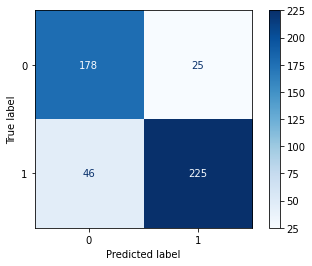

In [67]:
plot_confusion_matrix(lr,X_test,y_test, cmap='Blues',values_format='d');

In [ ]:
# going back up to add alien, aliens, sp, sleep paralysis and abductions to the stop list

# KNN Nearest Neighbors

In [70]:
knn=KNeighborsClassifier()

In [71]:
X=df.drop(columns=['title','body','subreddit2'])
y=df['subreddit2']

In [72]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=.25,
                                               random_state=42, 
                                               stratify=y)

In [73]:
cross_val_score(knn,X_train,y_train,cv=5).mean()

0.72400947459087

### Fit and score

In [74]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [75]:
knn.score(X_train,y_train)

0.8029739776951673

In [76]:
knn.score(X_test,y_test)

0.7298050139275766

## Time to test it!!!

In [90]:
Z_vec=vectorizer.transform(pd.Series(['it was dark and i was frozen. i cant remember what happened']))

In [91]:
lr.predict(Z_vec)

array([0])

In [85]:
ZZ_vec=vectorizer.transform(pd.Series(['i could not move and i was scared']))

In [86]:
lr.predict(ZZ_vec)

array([1])

In [92]:
ZZZ_vec=vectorizer.transform(pd.Series(['i was in my bed at night and my eyes were opened. there was a light and i thought it was a dream i could not move for a long time']))

In [93]:
lr.predict(ZZZ_vec)

array([1])